##### Análise de Recorte Específico

Por meio da análise dos dados do experimento no _software_ OpenBCI GUI, foram identificados trechos que apresentam picos de bandas específicas. A seguir, os principais momentos são evidenciados.

In [124]:
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [125]:
# Transform a string that represents a time value ("min:sec") into number and converts it to seconds
def convert_min_to_sec(time):
    minutes, seconds = map(int, time.split(":"))
    return minutes * 60 + seconds

# Transfor a string thats represents a range time "0:21 - 0:40" into index that will be used to cut data
def convert_time_range_to_index(timerange):
    start, end = map(str, timerange.split(" - "))
    new_start = convert_min_to_sec(start)
    new_end = convert_min_to_sec(end)
    
    index = []
    index.append(new_start * 250)
    index.append(new_end * 250)

    return index

In [126]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [127]:
# Carregando os dados
# gt = '../dataset-s7/GT/OpenBCI-RAW-2023-09-19_14-58-42_GT.txt'
# gt_ob = np.loadtxt(gt, delimiter=',', skiprows=5, usecols=range(1, 9))

ia = '../dataset-s7/IA/OpenBCI-RAW-2023-09-28_16-51-25_IA.txt'
ia_ob = np.loadtxt(ia, delimiter=',', skiprows=5, usecols=range(1, 9))

# tf = '../dataset-s7/TF/OpenBCI-RAW-2023-11-07_13-17-01_TF.txt'
# tf_ob = np.loadtxt(tf, delimiter=',', skiprows=5, usecols=range(1, 9))

In [128]:
# Aula GT
# 2:14 - 2:32
# 3:40 - 3:50
# 9:34 - 10:10

# Aula IA
timerange1 = "0:21 - 0:40"
timerange2 = "1:54 - 2:18"
timerange3 = "3:54 - 5:00"
timerange4 = "6:48 - 7:02"
timerange5 = "8:29 - 8:55"
timerange6 = "8:46 - 9:00"
timerange7 = "9:14 - 9:40"
timerange8 = "19:18 - 19:35"

index = []
index = convert_time_range_to_index(timerange3)

# Obtendo trecho de interesse
# data_cut_gt = gt_ob[1250:221000, :]
data_cut_ia = ia_ob[index[0]:index[1], :]
# data_cut_tf = tf_ob[67000:186250, :]


X = {
    # 'gt': mne.io.RawArray(data_cut_gt.T, info),
    'ia': mne.io.RawArray(data_cut_ia.T, info),
    # 'tf': mne.io.RawArray(data_cut_tf.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=16500
    Range : 0 ... 16499 =      0.000 ...    65.996 secs
Ready.


In [129]:
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [130]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 4            # Tamanho da janela de análise (4 em 4 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


total_pc = {}
# data_names = ('gt', 'ia', 'tf')
data_names = ('ia',)

# X contém os cinco conjuntos de dados de EEG para análise
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (4s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # Calculando a pontuação de cada banda para mostrar a porcentagem futura
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 16500 (66.0 s), ~1.0 MB, data loaded>
{'ia': [57.38, 0.0, 0.0, 42.62]}


In [131]:
rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')
    plt.show()


Insulina Ativa


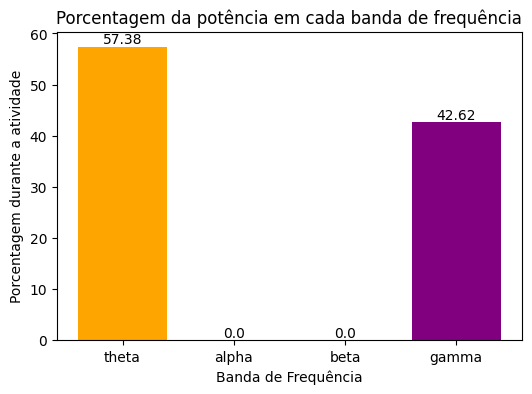

In [132]:
# print('Glucagon Tradicional')
# plot_bar(total_pc['gt'])

print('Insulina Ativa')
plot_bar(total_pc['ia'])

# print('Teste Final')
# plot_bar(total_pc['tf'])

In [133]:
def print_graphs(X):
    for i in range(X.shape[1]):
        plt.plot(X[:,i])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(X.shape[1]):
        # Fs = Frequency sample (taxa de amostragem): 250Hz
        plt.psd(X[:,i], Fs=250)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(X.shape[1]):
        plt.specgram(X[i,:], Fs=250)
    plt.title('Espectrograma')
    plt.show()

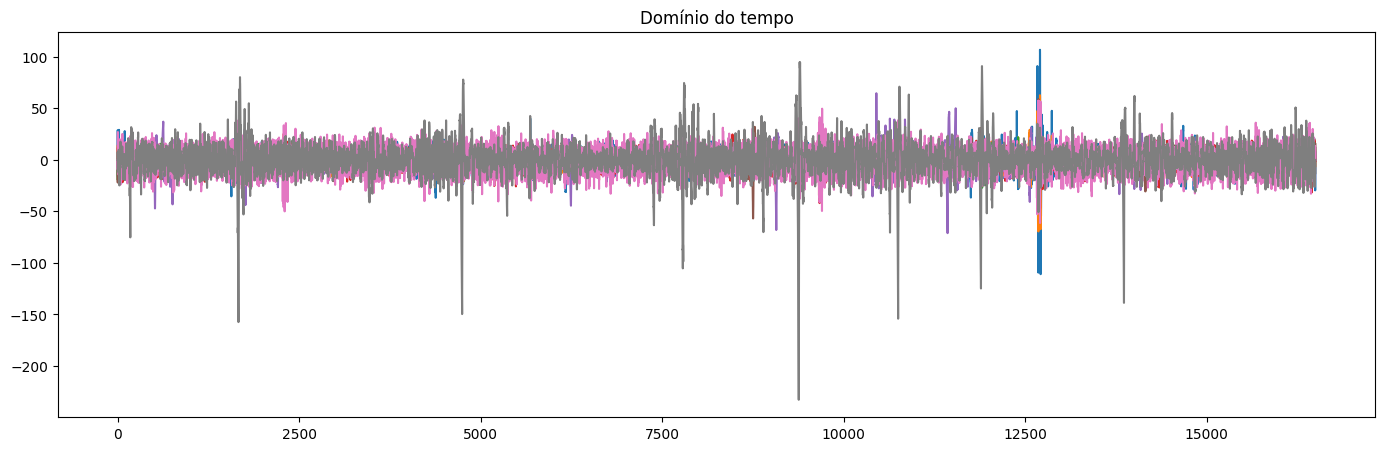

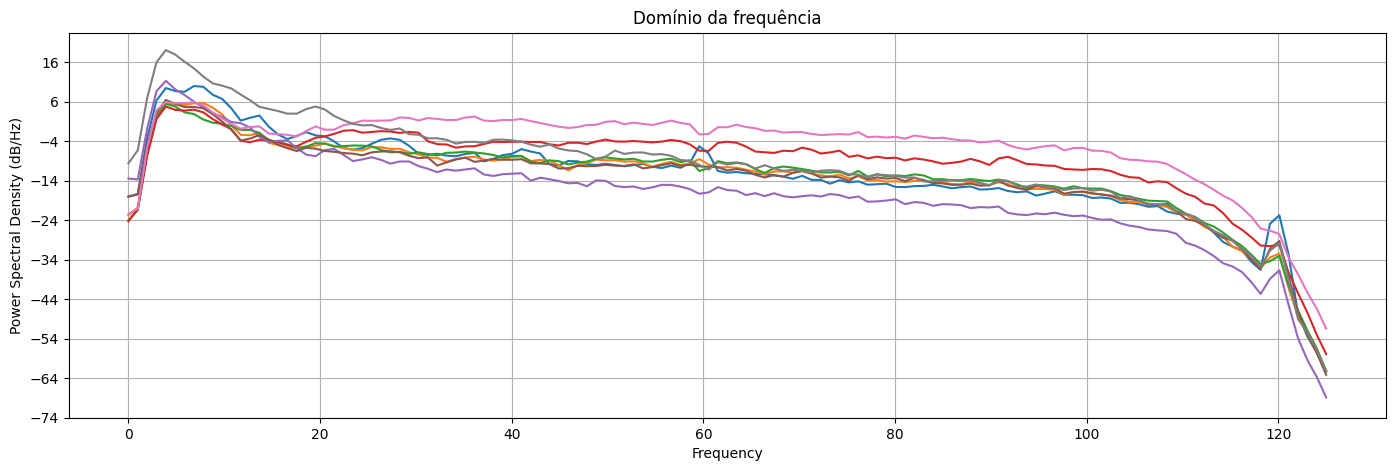

/tmp/ipykernel_4353/2146296300.py:14: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=8).
  plt.specgram(X[i,:], Fs=250)


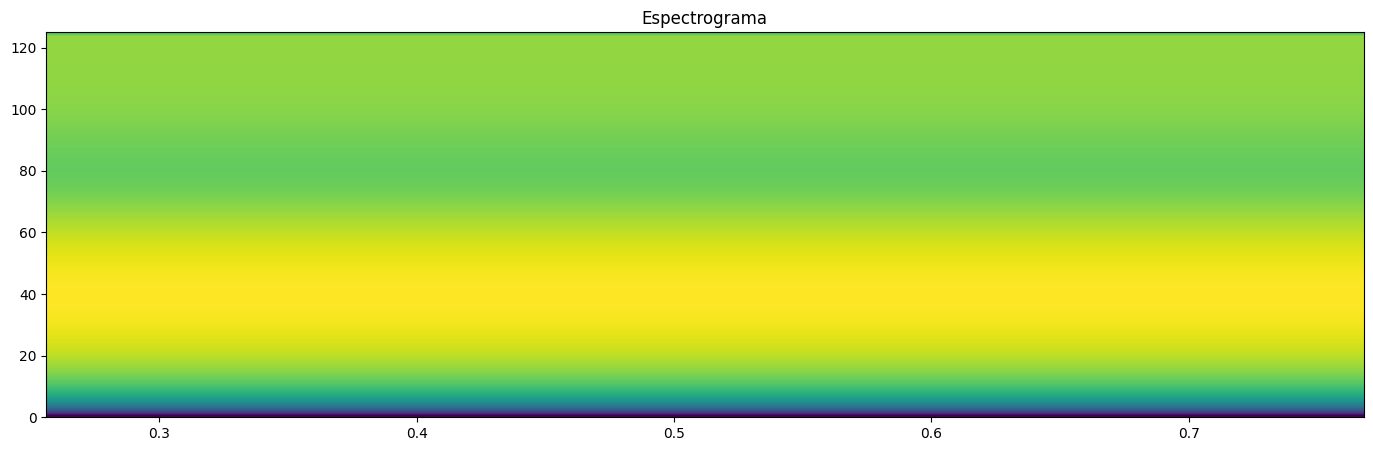

In [134]:
rcParams['figure.figsize'] = [17., 5.]

# for key in X:
#     print_graphs(X[key])

print_graphs(data_cut_ia)

1. Testar jumps com valores diferentes
    - timerange8 "19:18 - 19:35":
        - jump = 3: `'ia': [23.08, 0.0, 0.0, 76.92]`
        - jump = 5: `'ia': [0.0, 0.0, 0.0, 100.0]`
        - jump = 7: `'ia': [0.0, 0.0, 0.0, 100.0]`

    - timerange3 "3:54 - 5:00":
        - jump = 3: `'ia': [51.61, 1.61, 3.23, 43.55]`
        - jump = 4: `'ia': [57.38, 0.0, 0.0, 42.62]`
        - jump = 5: `'ia': [63.33, 0.0, 0.0, 36.67]`
        - jump = 7: `ia': [68.97, 0.0, 0.0, 31.03]`
- alternar entre 3 e 4.

2. Pesquisar quais eletrodos podem apresentar beta maior, inseri-los numa lista e passar para `ref_channels` em `set_eeg_reference`

3. Encontrar momentos do TF

4. Automatizar + housekeeping